# Dependencies trajectory following errors

Investigate the relations between the following three errors:
- Longitudinal error rate
- Lateral error
- Orientation error

And the three parameters:
- Acceleration
- Curvature
- Velocity

Resulting in 9 relations to explore


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union, List, Optional

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Ignore the GPU

### Import the `lib` directory
import pathlib
import sys

repo_directory = pathlib.Path().resolve().parents[1]
lib_module_dir = str(repo_directory.joinpath("lib"))
if lib_module_dir not in sys.path:
    sys.path.insert(0, str(repo_directory.joinpath("lib")))

from dual_gp_model_SVGP import DualGaussianProcessWrapper, make_unique_name, create_log_directory

2024-08-15 22:14:58.276151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 22:14:58.969804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
VelAcc = pd.read_csv("VelAcc.csv")
VelCurv = pd.read_csv("VelCurv.csv")

### 1. Fit GP models on the relations

In [3]:
"""Make GP models to be trained on the data to show correlations"""
training_dir = create_log_directory(str(pathlib.Path().resolve()))

def get_x_y_data(error_key, mask_name, quantity) -> tuple[np.ndarray, np.ndarray]:
    dataset = VelCurv if quantity == "velocities" or quantity == "curvatures" else VelAcc
    mask = dataset[mask_name] if mask_name else np.ones(len(dataset), dtype=np.bool_)
    values, errors = dataset[quantity][mask], dataset[error_key][mask]
    return values.to_numpy(), errors.to_numpy()


def setup_model(x_data, y_data, use_lognormal, model_name):
    train_mask = np.ones(len(x_data), dtype=np.bool_)
    model = DualGaussianProcessWrapper(
        x_data=x_data,
        y_data=y_data,
        train_mask=train_mask,
        no_inducing_points=12,
        data_directory=training_dir,
        use_lognormal=use_lognormal,
    )
    # rename the directory
    new_name = make_unique_name(os.path.abspath(os.path.join(model.log_directory, os.pardir, model_name)))
    os.rename(model.log_directory, new_name)
    model.log_directory = new_name
    model.params_directory = os.path.join(model.log_directory, "params")
    model.perform_directory = os.path.join(model.log_directory, "performance")
    return model

mask_names = {
    "long_dt_errors": None,
    "lat_errors": "mask_lat",
    "orient_errors": "mask_orient",
}
use_lognormals = {
    "long_dt_errors": False,
    "lat_errors": True,
    "orient_errors": True,
}
scale_factors = {
    "long_dt_errors": 1.,
    "lat_errors": 10000.,
    "orient_errors": 10.,
}
models = {}

for error_key in ["long_dt_errors", "lat_errors", "orient_errors"]:
    for quantity in ["accelerations", "curvatures", "velocities"]:

        mask_name = mask_names[error_key]
        use_lognormal = use_lognormals[error_key]
        scale_factor = scale_factors[error_key]

        model_name = f"{quantity}_vs_{error_key}"

        x_data, y_data = get_x_y_data(error_key, mask_name, quantity)
        y_data = y_data * scale_factor

        model = setup_model(x_data, y_data, use_lognormal, model_name)
        models[model_name] = model

2024-08-15 22:15:02.493360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-15 22:15:02.493386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: christiaan-HP-ZBook-Studio-G5
2024-08-15 22:15:02.493392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: christiaan-HP-ZBook-Studio-G5
2024-08-15 22:15:02.493467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.90.7
2024-08-15 22:15:02.493501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.90.7
2024-08-15 22:15:02.493507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.90.7


  0%|          | 0/500 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead


2024-08-15 22:15:06.969187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 22:15:07.008899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -15705.17 	 test_elbo = -13.02
Epoch 2: 	 train_elbo = -14073.54 	 test_elbo = -28.96
Epoch 3: 	 train_elbo = -10658.88 	 test_elbo = -160.79
Epoch 4: 	 train_elbo = -4892.71 	 test_elbo = -567.79
Epoch 5: 	 train_elbo = -548.65 	 test_elbo = -1279.94
Epoch 6: 	 train_elbo = 956.17 	 test_elbo = -1248.97
Epoch 7: 	 train_elbo = 4730.49 	 test_elbo = -1267.24
Epoch 8: 	 train_elbo = 7966.77 	 test_elbo = -1396.71
Epoch 9: 	 train_elbo = 10326.76 	 test_elbo = -1569.39
Epoch 10: 	 train_elbo = 12051.99 	 test_elbo = -1717.53
Epoch 11: 	 train_elbo = 13200.94 	 test_elbo = -1800.05
Epoch 12: 	 train_elbo = 13833.57 	 test_elbo = -1804.65
Epoch 13: 	 train_elbo = 14146.52 	 test_elbo = -1748.83
Epoch 14: 	 train_elbo = 14325.27 	 test_elbo = -1660.24
Epoch 15: 	 train_elbo = 14470.80 	 test_elbo = -1558.87
Epoch 16: 	 train_elbo = 14625.15 	 test_elbo = -1455.07
Epoch 17: 	 train_elbo = 14799.72 	 test_elbo = -1353.36
Epoch 18: 	 train_elbo = 14991.56 	 test_elbo = 

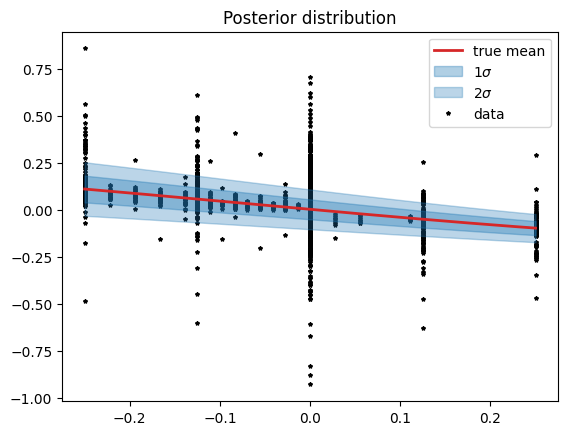

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-15 22:27:28.221106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 22:27:28.253516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -14309.76 	 test_elbo = -16.74
Epoch 2: 	 train_elbo = -13430.26 	 test_elbo = -17.32
Epoch 3: 	 train_elbo = -11978.15 	 test_elbo = -37.14
Epoch 4: 	 train_elbo = -9467.27 	 test_elbo = -132.18
Epoch 5: 	 train_elbo = -5524.79 	 test_elbo = -389.52
Epoch 6: 	 train_elbo = -4203.02 	 test_elbo = -682.87
Epoch 7: 	 train_elbo = -150.97 	 test_elbo = -861.01
Epoch 8: 	 train_elbo = 3726.99 	 test_elbo = -1189.53
Epoch 9: 	 train_elbo = 7011.75 	 test_elbo = -1595.77
Epoch 10: 	 train_elbo = 9675.34 	 test_elbo = -1974.11
Epoch 11: 	 train_elbo = 11524.98 	 test_elbo = -2214.08
Epoch 12: 	 train_elbo = 12291.42 	 test_elbo = -2221.72
Epoch 13: 	 train_elbo = 12441.49 	 test_elbo = -2061.34
Epoch 14: 	 train_elbo = 12435.99 	 test_elbo = -1850.14
Epoch 15: 	 train_elbo = 12513.49 	 test_elbo = -1646.99
Epoch 16: 	 train_elbo = 12716.79 	 test_elbo = -1473.96
Epoch 17: 	 train_elbo = 12973.42 	 test_elbo = -1334.66
Epoch 18: 	 train_elbo = 13204.18 	 test_elbo = -12

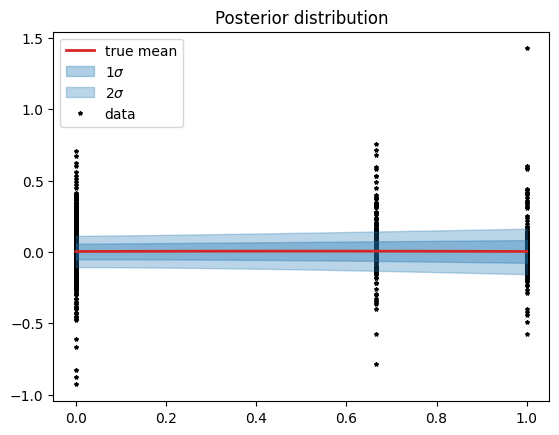

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-15 22:38:25.870321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 22:38:25.904440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -14310.35 	 test_elbo = -12.28
Epoch 2: 	 train_elbo = -13449.67 	 test_elbo = -12.70
Epoch 3: 	 train_elbo = -8971.28 	 test_elbo = -36.86
Epoch 4: 	 train_elbo = -16792.31 	 test_elbo = -680.59
Epoch 5: 	 train_elbo = -4974.56 	 test_elbo = -485.57
Epoch 6: 	 train_elbo = -3382.50 	 test_elbo = -416.47
Epoch 7: 	 train_elbo = -2255.83 	 test_elbo = -361.33
Epoch 8: 	 train_elbo = -1244.10 	 test_elbo = -311.10
Epoch 9: 	 train_elbo = -198.49 	 test_elbo = -264.13
Epoch 10: 	 train_elbo = 937.07 	 test_elbo = -223.02
Epoch 11: 	 train_elbo = 2174.49 	 test_elbo = -191.14
Epoch 12: 	 train_elbo = 3509.31 	 test_elbo = -171.69
Epoch 13: 	 train_elbo = 4928.89 	 test_elbo = -167.53
Epoch 14: 	 train_elbo = 6411.32 	 test_elbo = -180.99
Epoch 15: 	 train_elbo = 7920.14 	 test_elbo = -213.20
Epoch 16: 	 train_elbo = 9397.36 	 test_elbo = -263.15
Epoch 17: 	 train_elbo = 10760.49 	 test_elbo = -326.36
Epoch 18: 	 train_elbo = 11914.92 	 test_elbo = -394.18
Epoch 19: 

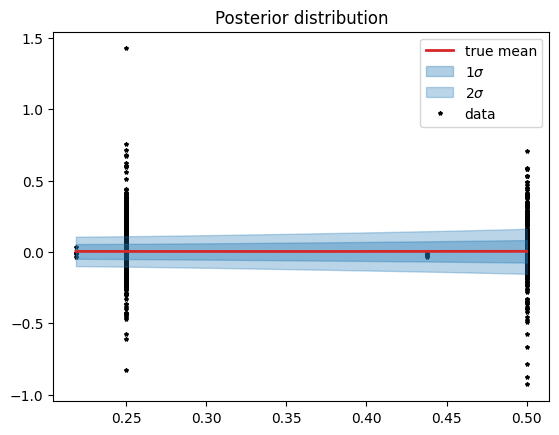

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-15 22:49:21.150415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 22:49:21.182326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -577.00 	 test_elbo = -84.85
Epoch 2: 	 train_elbo = -567.08 	 test_elbo = -82.10
Epoch 3: 	 train_elbo = -571.72 	 test_elbo = -79.60
Epoch 4: 	 train_elbo = -534.20 	 test_elbo = -78.30
Epoch 5: 	 train_elbo = -525.79 	 test_elbo = -75.06
Epoch 6: 	 train_elbo = -520.56 	 test_elbo = -71.24
Epoch 7: 	 train_elbo = -521.04 	 test_elbo = -67.80
Epoch 8: 	 train_elbo = -515.39 	 test_elbo = -64.76
Epoch 9: 	 train_elbo = -511.35 	 test_elbo = -62.07
Epoch 10: 	 train_elbo = -507.61 	 test_elbo = -59.53
Epoch 11: 	 train_elbo = -504.22 	 test_elbo = -57.11
Epoch 12: 	 train_elbo = -501.01 	 test_elbo = -54.82
Epoch 13: 	 train_elbo = -497.96 	 test_elbo = -52.67
Epoch 14: 	 train_elbo = -495.11 	 test_elbo = -50.66
Epoch 15: 	 train_elbo = -492.61 	 test_elbo = -48.77
Epoch 16: 	 train_elbo = -490.80 	 test_elbo = -47.04
Epoch 17: 	 train_elbo = -488.90 	 test_elbo = -45.47
Epoch 18: 	 train_elbo = -486.69 	 test_elbo = -44.05
Epoch 19: 	 train_elbo = -484.74 	 te

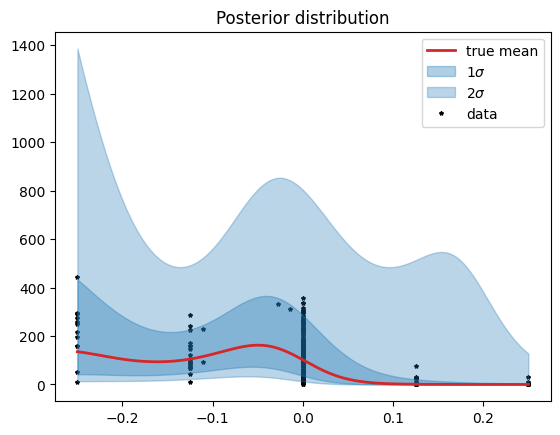

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-15 22:54:32.140693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 22:54:32.174687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -331.97 	 test_elbo = -22.67
Epoch 2: 	 train_elbo = -331.31 	 test_elbo = -22.42
Epoch 3: 	 train_elbo = -330.64 	 test_elbo = -22.17
Epoch 4: 	 train_elbo = -329.95 	 test_elbo = -21.93
Epoch 5: 	 train_elbo = -329.20 	 test_elbo = -21.70
Epoch 6: 	 train_elbo = -328.35 	 test_elbo = -21.49
Epoch 7: 	 train_elbo = -327.39 	 test_elbo = -21.30
Epoch 8: 	 train_elbo = -326.29 	 test_elbo = -21.15
Epoch 9: 	 train_elbo = -325.03 	 test_elbo = -21.03
Epoch 10: 	 train_elbo = -323.64 	 test_elbo = -20.96
Epoch 11: 	 train_elbo = -336.60 	 test_elbo = -20.95
Epoch 12: 	 train_elbo = -322.32 	 test_elbo = -21.21
Epoch 13: 	 train_elbo = -320.77 	 test_elbo = -21.12
Epoch 14: 	 train_elbo = -319.33 	 test_elbo = -21.09
Epoch 15: 	 train_elbo = -317.95 	 test_elbo = -21.09
Epoch 16: 	 train_elbo = -316.66 	 test_elbo = -21.11
Epoch 17: 	 train_elbo = -315.36 	 test_elbo = -21.14
Epoch 18: 	 train_elbo = -314.08 	 test_elbo = -21.16
Epoch 19: 	 train_elbo = -312.85 	 te

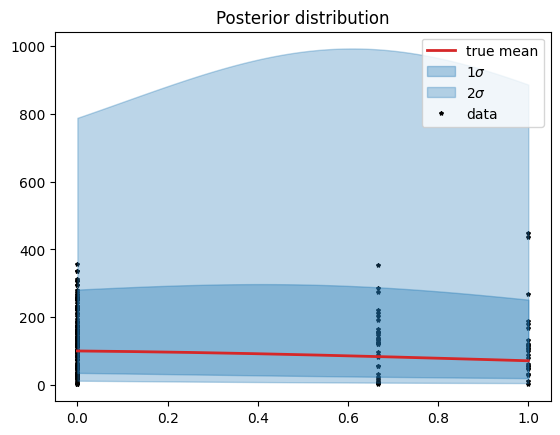

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-15 22:59:45.581998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 22:59:45.614576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -327.06 	 test_elbo = -18.78
Epoch 2: 	 train_elbo = -326.46 	 test_elbo = -18.61
Epoch 3: 	 train_elbo = -325.83 	 test_elbo = -18.44
Epoch 4: 	 train_elbo = -325.14 	 test_elbo = -18.28
Epoch 5: 	 train_elbo = -324.11 	 test_elbo = -18.14
Epoch 6: 	 train_elbo = -323.27 	 test_elbo = -18.00
Epoch 7: 	 train_elbo = -322.34 	 test_elbo = -17.87
Epoch 8: 	 train_elbo = -322.51 	 test_elbo = -17.75
Epoch 9: 	 train_elbo = -320.46 	 test_elbo = -17.68
Epoch 10: 	 train_elbo = -319.66 	 test_elbo = -17.59
Epoch 11: 	 train_elbo = -318.82 	 test_elbo = -17.48
Epoch 12: 	 train_elbo = -318.00 	 test_elbo = -17.43
Epoch 13: 	 train_elbo = -317.21 	 test_elbo = -17.30
Epoch 14: 	 train_elbo = -316.31 	 test_elbo = -17.17
Epoch 15: 	 train_elbo = -315.39 	 test_elbo = -17.04
Epoch 16: 	 train_elbo = -314.45 	 test_elbo = -16.92
Epoch 17: 	 train_elbo = -313.51 	 test_elbo = -16.80
Epoch 18: 	 train_elbo = -312.57 	 test_elbo = -16.68
Epoch 19: 	 train_elbo = -311.64 	 te

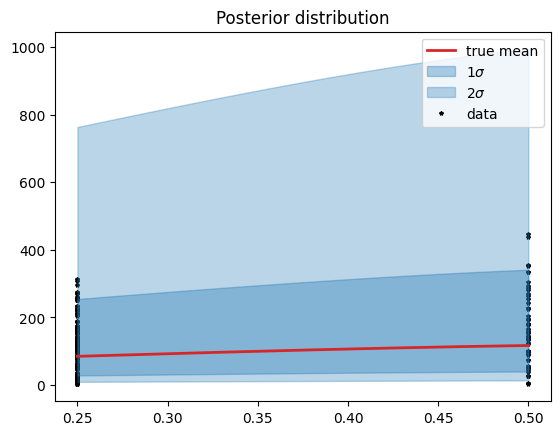

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-15 23:04:55.871090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 23:04:55.903788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -653.47 	 test_elbo = -10.83
Epoch 2: 	 train_elbo = -651.14 	 test_elbo = -10.69
Epoch 3: 	 train_elbo = -648.13 	 test_elbo = -10.60
Epoch 4: 	 train_elbo = -644.34 	 test_elbo = -10.61
Epoch 5: 	 train_elbo = -639.95 	 test_elbo = -10.76
Epoch 6: 	 train_elbo = -635.16 	 test_elbo = -11.05
Epoch 7: 	 train_elbo = -630.11 	 test_elbo = -11.45
Epoch 8: 	 train_elbo = -624.89 	 test_elbo = -11.92
Epoch 9: 	 train_elbo = -619.82 	 test_elbo = -12.41
Epoch 10: 	 train_elbo = -615.42 	 test_elbo = -12.84
Epoch 11: 	 train_elbo = -611.93 	 test_elbo = -13.14
Epoch 12: 	 train_elbo = -609.15 	 test_elbo = -13.29
Epoch 13: 	 train_elbo = -606.81 	 test_elbo = -13.30
Epoch 14: 	 train_elbo = -604.79 	 test_elbo = -13.21
Epoch 15: 	 train_elbo = -603.02 	 test_elbo = -13.05
Epoch 16: 	 train_elbo = -601.45 	 test_elbo = -12.85
Epoch 17: 	 train_elbo = -600.05 	 test_elbo = -12.63
Epoch 18: 	 train_elbo = -598.79 	 test_elbo = -12.40
Epoch 19: 	 train_elbo = -597.67 	 te

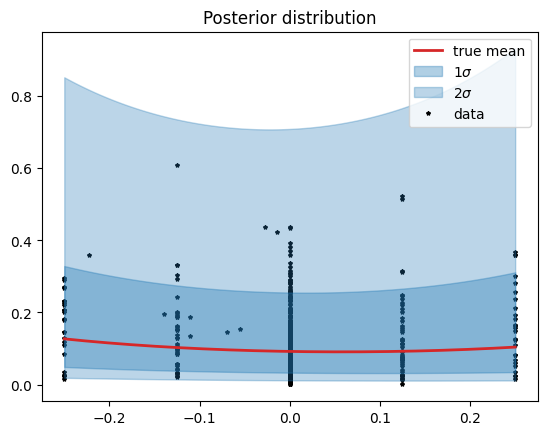

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-15 23:10:10.515210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 23:10:10.548132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -612.19 	 test_elbo = -13.55
Epoch 2: 	 train_elbo = -609.96 	 test_elbo = -13.34
Epoch 3: 	 train_elbo = -607.52 	 test_elbo = -13.16
Epoch 4: 	 train_elbo = -604.72 	 test_elbo = -13.00
Epoch 5: 	 train_elbo = -601.42 	 test_elbo = -12.90
Epoch 6: 	 train_elbo = -597.52 	 test_elbo = -12.87
Epoch 7: 	 train_elbo = -593.06 	 test_elbo = -12.96
Epoch 8: 	 train_elbo = -588.40 	 test_elbo = -13.17
Epoch 9: 	 train_elbo = -584.09 	 test_elbo = -13.47
Epoch 10: 	 train_elbo = -580.18 	 test_elbo = -13.79
Epoch 11: 	 train_elbo = -576.58 	 test_elbo = -14.11
Epoch 12: 	 train_elbo = -573.42 	 test_elbo = -14.43
Epoch 13: 	 train_elbo = -570.79 	 test_elbo = -14.70
Epoch 14: 	 train_elbo = -568.72 	 test_elbo = -14.92
Epoch 15: 	 train_elbo = -567.15 	 test_elbo = -15.07
Epoch 16: 	 train_elbo = -565.96 	 test_elbo = -15.13
Epoch 17: 	 train_elbo = -565.07 	 test_elbo = -15.13
Epoch 18: 	 train_elbo = -564.43 	 test_elbo = -15.08
Epoch 19: 	 train_elbo = -564.02 	 te

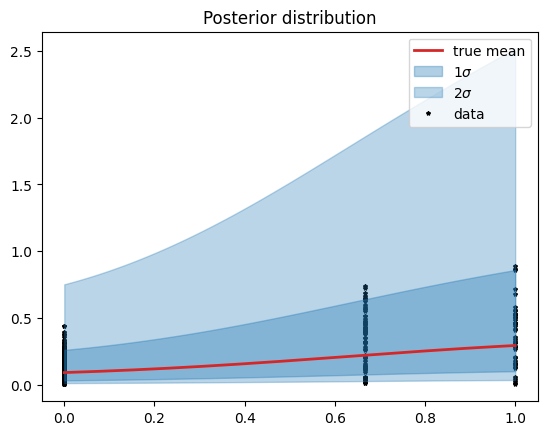

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-15 23:15:29.176241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 23:15:29.208338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -624.24 	 test_elbo = -10.04
Epoch 2: 	 train_elbo = -622.64 	 test_elbo = -9.91
Epoch 3: 	 train_elbo = -620.87 	 test_elbo = -9.78
Epoch 4: 	 train_elbo = -619.05 	 test_elbo = -9.66
Epoch 5: 	 train_elbo = -617.07 	 test_elbo = -9.55
Epoch 6: 	 train_elbo = -614.89 	 test_elbo = -9.45
Epoch 7: 	 train_elbo = -612.57 	 test_elbo = -9.36
Epoch 8: 	 train_elbo = -610.32 	 test_elbo = -9.28
Epoch 9: 	 train_elbo = -607.79 	 test_elbo = -9.22
Epoch 10: 	 train_elbo = -605.57 	 test_elbo = -9.16
Epoch 11: 	 train_elbo = -603.25 	 test_elbo = -9.12
Epoch 12: 	 train_elbo = -600.84 	 test_elbo = -9.08
Epoch 13: 	 train_elbo = -598.37 	 test_elbo = -9.05
Epoch 14: 	 train_elbo = -595.91 	 test_elbo = -9.03
Epoch 15: 	 train_elbo = -593.50 	 test_elbo = -9.03
Epoch 16: 	 train_elbo = -591.27 	 test_elbo = -9.03
Epoch 17: 	 train_elbo = -589.72 	 test_elbo = -9.04
Epoch 18: 	 train_elbo = -587.78 	 test_elbo = -9.07
Epoch 19: 	 train_elbo = -586.56 	 test_elbo = -9.08
E

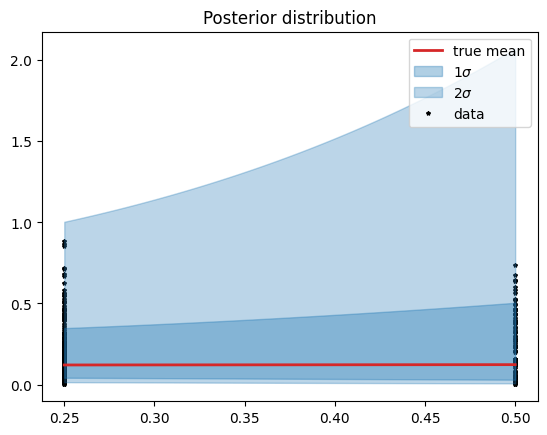

In [4]:
### Fit the GPS

for model_name, model in models.items():
    model.train(500)
    model.plot_posterior()

### 2. Visualize the data and the GP fits

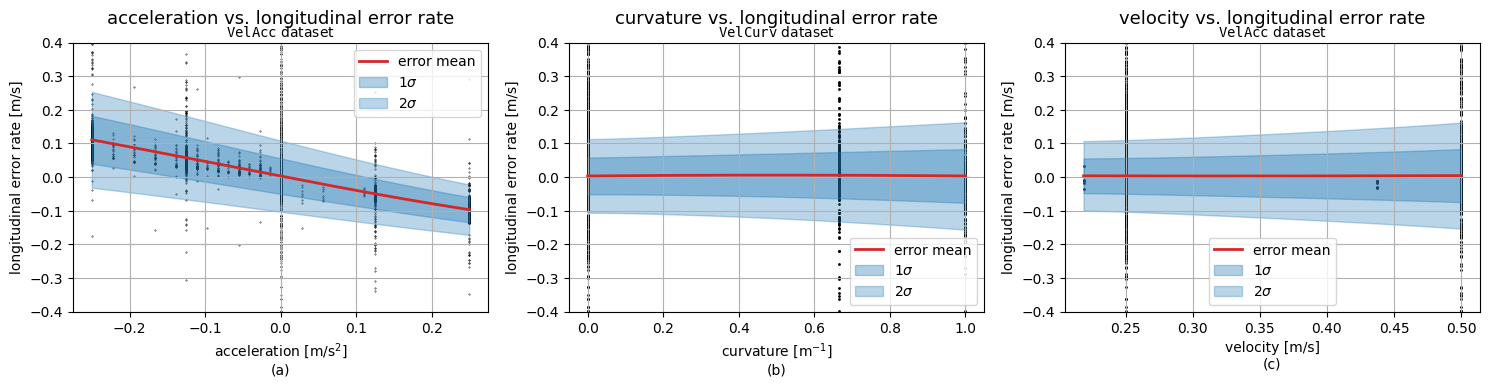

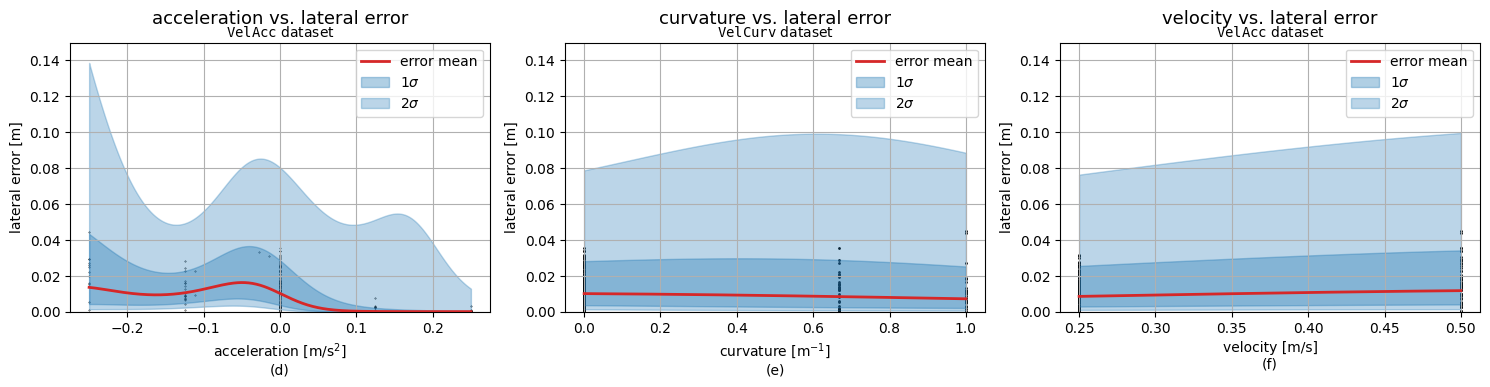

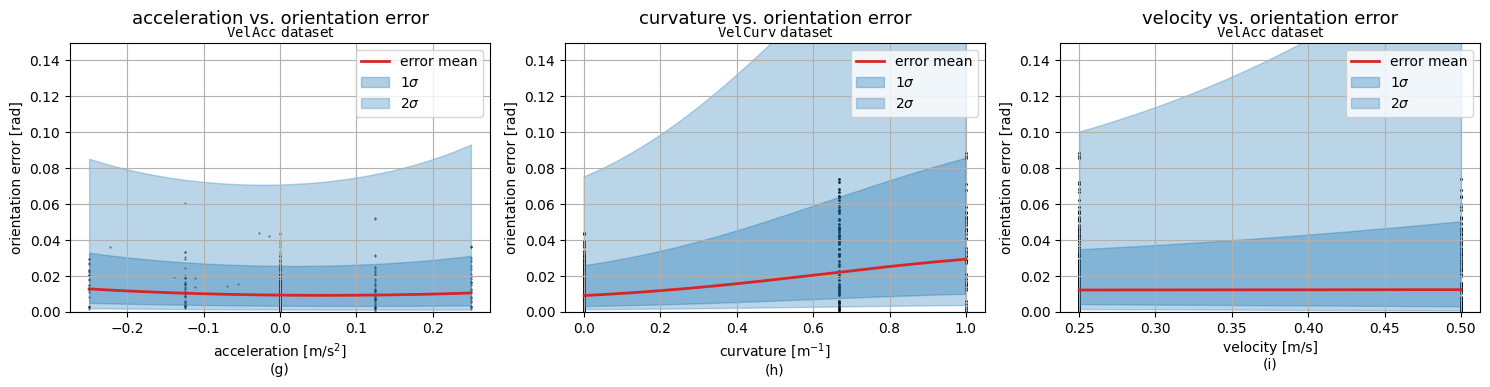

In [5]:
### Plot the data with the GPs to explore the relation
ylims_dict = {
    "long_dt_errors": (-0.4, 0.4),
    "lat_errors": (0, 0.15),
    "orient_errors": (0, 0.15),
}

import string
alphabet_iter = iter(string.ascii_lowercase)

def add_title(ax, quantity_name, error_name, dataset_name):
    ax.text(x=0.5, y=1.07, s=f"{quantity_name} vs. {error_name}", fontsize=13, ha="center", transform=ax.transAxes)
    subtitle_str = {
        "VelCurv" : r'$\mathtt{VelCurv}$' + " dataset",
        "VelAcc" : r'$\mathtt{VelAcc}$' + " dataset",
    }
    ax.text(x=0.5, y=1.02, s=subtitle_str[dataset_name], fontsize=10, ha="center", transform=ax.transAxes)

def plot_gp(ax, model: DualGaussianProcessWrapper, scale_factor: float) -> None:
    use_lognormal = model.use_lognormal
    x_test = np.linspace(model.x_data.min(), model.x_data.max(), 300)
    mean, variance = model.fast_predict_y(x_test.reshape(-1, 1))

    mean = mean.numpy().squeeze()  # type: ignore
    mean_transformed = (np.exp(mean) if use_lognormal else mean) / scale_factor
    ax.plot(x_test, mean_transformed, color="tab:red", label="error mean", linewidth=2, zorder=10)

    std = np.sqrt(variance.numpy().squeeze())  # type: ignore
    for k in range(1, 3):
        lb = np.exp((mean - k * std)) if use_lognormal else (mean - k * std)
        ub = np.exp((mean + k * std)) if use_lognormal else (mean + k * std)
        ax.fill_between(x_test, lb / scale_factor, ub / scale_factor, color="tab:blue", alpha=0.4 - 0.05 * k, label=rf"${k}\sigma$")

def plot_debug_gp(xs: np.ndarray, errors: np.ndarray, x_test_points: Union[List, np.ndarray], use_lognormal: bool, ax) -> None:
    if use_lognormal:
        errors_transformed = np.log(errors)
        transform = np.exp
    else:
        errors_transformed = errors.copy()
        transform = lambda x: x
    means, stds = [], []
    for x_test in x_test_points:
        mask = xs == x_test
        means.append(errors_transformed[mask].mean())
        stds.append(errors_transformed[mask].std())
    means, stds = np.array(means), np.array(stds)
    ax.scatter(x_test_points, transform(means), color="tab:orange", ls="--", label="debug mean", zorder=10)
    ax.vlines(x_test_points, transform(means - stds), transform(means + stds), color="tab:green", lw=7, label="debug std")
    ax.vlines(x_test_points, transform(means - 2 * stds), transform(means + 2 * stds), color="tab:green", lw=3.5, alpha=1)

def plot_dependencies_with_gps(
    error_key: str,
    mask_name: Optional[str] = None,
    name: Optional[str] = None,
    unit: Optional[str] = None,
    do_plot_gps: bool = True,
    do_plot_debug_gps: bool = False,
) -> None:
    """Plot the dependency between the error and the velocity, acceleration and radius (presence of corners)"""
    scale_factor = scale_factors[error_key]

    no_of_plots = 3
    fig, axs = plt.subplots(1, no_of_plots, figsize=(no_of_plots*5, 4))
    axs_iter = iter(axs)

    """plot: acceleration vs. error"""
    ax = next(axs_iter)

    mask = VelAcc[mask_name] if mask_name else np.ones(len(VelAcc), dtype=np.bool_)
    accelerations, errors = VelAcc["accelerations"][mask].to_numpy(), VelAcc[error_key][mask].to_numpy()
    ax.scatter(accelerations, errors, color='k', s=0.1)
    if do_plot_gps:
        plot_gp(ax, models[f"accelerations_vs_{error_key}"], scale_factor)
    if do_plot_debug_gps:
        test_points = [-0.25, -0.125, 0., 0.125, 0.25]
        plot_debug_gp(
            accelerations, errors, test_points, models[f"accelerations_vs_{error_key}"].use_lognormal, ax,
        )
    ax.set_ylabel(f"{name} [{unit}]")
    # ax.set_xlabel("acceleration [m/s" + r"$^2$" + "]\n\na)")
    ax.set_xlabel("acceleration [m/s" + r"$^2$" + "]" + f"\n({next(alphabet_iter)})")
    if name is not None:
        add_title(ax, "acceleration", name, "VelAcc")
    ax.grid()
    ax.legend()
    ax.set_ylim(ylims_dict[error_key])

    ylim = ax.get_ylim()

    """plot: curvature vs. error"""
    ax = next(axs_iter) # curvature plot vs. error -- common data: v = 0.25, 0.5 and a = 0

    mask = VelCurv[mask_name] if mask_name else np.ones(len(VelCurv), dtype=np.bool_)
    curvatures, errors = VelCurv["curvatures"][mask].to_numpy(), VelCurv[error_key][mask].to_numpy()
    ax.scatter(curvatures, errors, s=1, color='k')
    if do_plot_gps:
        plot_gp(ax, models[f"curvatures_vs_{error_key}"], scale_factor)
    if do_plot_debug_gps:
        test_points = [0, 2/3, 1.]
        plot_debug_gp(curvatures, errors, test_points, models[f"curvatures_vs_{error_key}"].use_lognormal, ax)
    ax.set_ylabel(f"{name} [{unit}]")
    # ax.set_xlabel("curvature [m" + r"$^{-1}$"+"]\n\nb)")
    ax.set_xlabel("curvature [m" + r"$^{-1}$"+"]" + f"\n({next(alphabet_iter)})")
    if name is not None:
        add_title(ax, "curvature", name, "VelCurv")
    ax.grid()
    ax.legend()
    ax.set_ylim(ylim)

    """plot: velocity vs. error"""
    ax = next(axs_iter) # velocity vs. error plot -- common data: v = 0.25 and 0.5 where a = 0.

    mask = VelCurv[mask_name] if mask_name else np.ones(len(VelCurv), dtype=np.bool_)
    velocities, errors = VelCurv["velocities"][mask].to_numpy(), VelCurv[error_key][mask].to_numpy()
    ax.scatter(velocities, errors, s=1, color='k')
    if do_plot_gps:
        plot_gp(ax, models[f"velocities_vs_{error_key}"], scale_factor)
    if do_plot_debug_gps:
        test_points = [0.25, 0.5]
        plot_debug_gp(velocities, errors, test_points, models[f"velocities_vs_{error_key}"].use_lognormal, ax)  
    ax.set_ylabel(f"{name} [{unit}]")
    # ax.set_xlabel("velocity [m/s]\n\nc)")
    ax.set_xlabel("velocity [m/s]" + f"\n({next(alphabet_iter)})")
    if name is not None:
        add_title(ax, "velocity", name, "VelAcc")
    ax.grid()
    ax.legend()
    ax.set_ylim(ylim)

    plt.tight_layout()
    # plt.savefig(os.path.join("/home/christiaan/thesis/thesis_code/plots", f"dependency_{error_key}.pdf"), bbox_inches='tight')
    plt.savefig(f"dependency_{error_key}.pdf", bbox_inches='tight')
    plt.savefig(f"dependency_{error_key}.png", dpi=300, bbox_inches='tight')
    plt.show()

%matplotlib inline
plt.close("all")
plot_dependencies_with_gps("long_dt_errors", None, "longitudinal error rate", "m/s")
plot_dependencies_with_gps("lat_errors","mask_lat", "lateral error", "m")
plot_dependencies_with_gps("orient_errors", "mask_orient", "orientation error", "rad")